# 2. Feature selection
##### W tej części analizy postaram się wybrać zmienne, które zawierają najwięcej informacji wartościowych na potrzeby naszego modelu. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

Zaczniemy od sprawdzenia jak wygląda macierz kolelacji wszystkich naszych zmiennych.

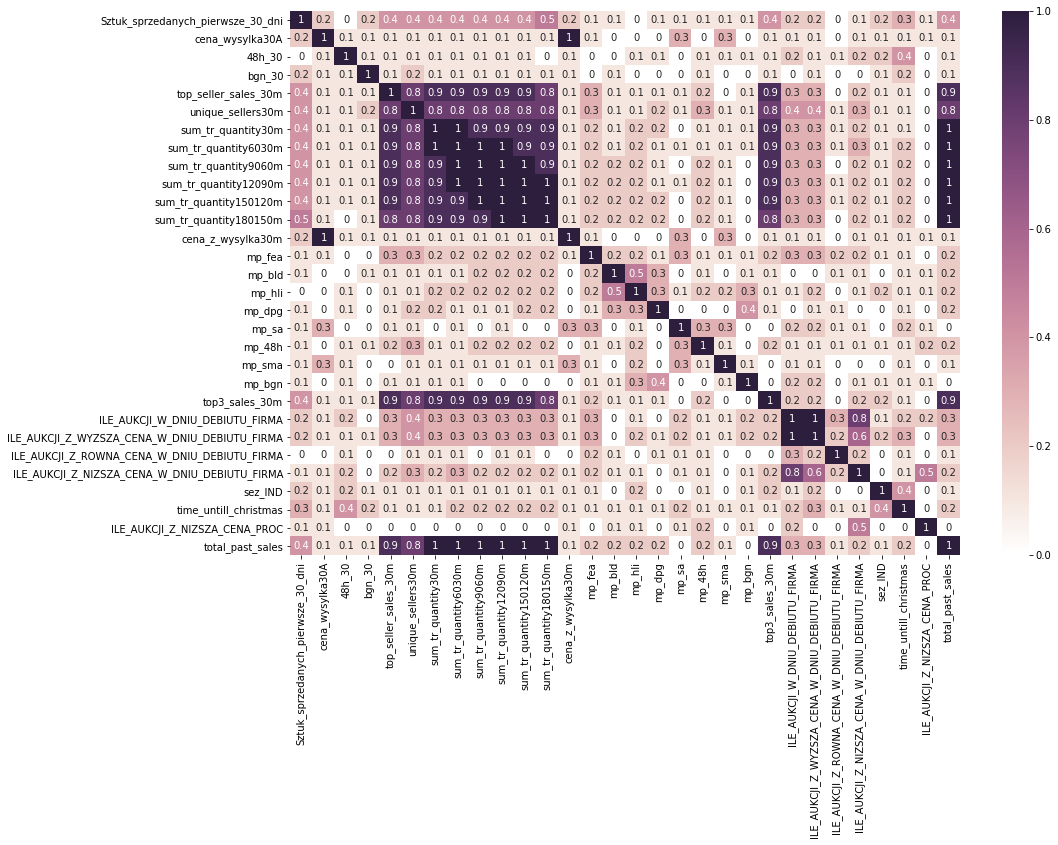

In [2]:
df = pd.read_pickle('data/data_after_cleaning.pkl')
df = df[df['Sztuk_sprzedanych_pierwsze_30_dni']<300]
plt.figure(figsize=(15, 10))
ax = sns.heatmap(np.abs(df.corr().round(decimals=1)),
                 cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                 annot=True)

Od razu można zauważyć, że parę zmiennych jest tożsamych - ich korelacja wynosi równo 1. Istnieje też kilka zmiennych, których korelacja wynosi >0.9. Pozbędziemy się tych bardzo mocno skorelowanych duplikatów.

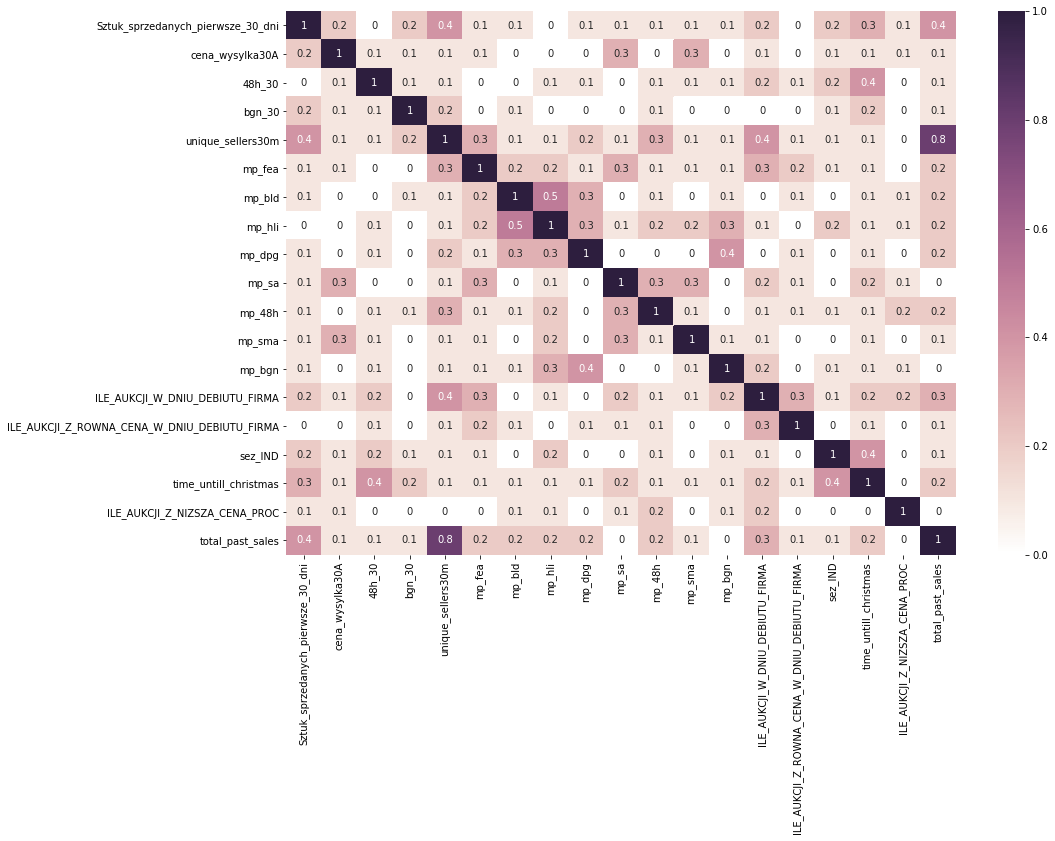

In [3]:
df.drop([
    'cena_z_wysylka30m',
    'ILE_AUKCJI_Z_WYZSZA_CENA_W_DNIU_DEBIUTU_FIRMA',
    'sum_tr_quantity6030m',
    'sum_tr_quantity9060m',
    'sum_tr_quantity12090m',
    'sum_tr_quantity150120m',
    'sum_tr_quantity180150m',
    'ILE_AUKCJI_Z_NIZSZA_CENA_W_DNIU_DEBIUTU_FIRMA',
    'sum_tr_quantity30m',
    'top3_sales_30m',
    'top_seller_sales_30m'],
    axis=1, inplace=True)

plt.figure(figsize=(15, 10))
ax = sns.heatmap(np.abs(df
                        .corr()
                        .round(decimals=1)),
                 cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                 annot=True)

Do selekcji zmiennych można podejść na wiele różnych sposobów. W tej analizie zdecydowałem się na selekcję zmiennych na podstawie ich istotnościu uzyskanej jako parametr lasu losowego. Pozwoli to uzyskać dobrej jakości zmienne, bez względu na to, czy są liniowo zależne ze zmienną objaśniającą. Dodatkowo podczas takiej selekcji rozkład naszych zmiennych nie jest istotny - algorytmy bazowane na drzewach są w stanie wyłapać relacje niezależnie od rozkładu. 

Ranking:
1. total_past_sales  (0.20)
2. time_untill_christmas  (0.12)
3. sez_IND  (0.11)
4. bgn_30  (0.09)
5. mp_fea  (0.08)
6. unique_sellers30m  (0.07)
7. mp_sa  (0.06)
8. cena_wysylka30A  (0.05)
9. ILE_AUKCJI_W_DNIU_DEBIUTU_FIRMA  (0.04)
10. mp_48h  (0.03)
11. mp_bld  (0.03)
12. ILE_AUKCJI_Z_NIZSZA_CENA_PROC  (0.03)
13. 48h_30  (0.03)
14. mp_sma  (0.02)
15. ILE_AUKCJI_Z_ROWNA_CENA_W_DNIU_DEBIUTU_FIRMA  (0.02)
16. mp_hli  (0.01)
17. mp_dpg  (0.01)
18. mp_bgn  (0.01)


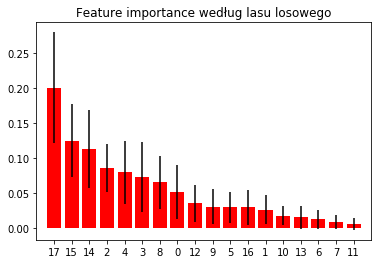

In [4]:
X = df.drop('Sztuk_sprzedanych_pierwsze_30_dni', axis=1)
y = df['Sztuk_sprzedanych_pierwsze_30_dni']


forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
# Odchylenia istotniości zmiennych w każdym z drzew 
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Pokaż ranking zmiennych
print("Ranking:")

for f in range(X.shape[1]):
    print("{}. {}  ({:.2f})".format(f + 1, X.columns[indices[f]], importances[indices[f]]))

# Wykres istotności zmiennych
plt.figure()
plt.title("Feature importance według lasu losowego")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Na tym etapie zdecydowałem się pozostawić tylko 5 najbardziej istotnych zmiennych. Pozwoli to skupić się na nich w dużo większym wymiarze. Dodatkowo przy tak małej ilości obserwacji warto maksymalnie ograniczać liczbę zmiennych.

In [5]:
top_5_features = ['total_past_sales',
                'time_untill_christmas',
                'sez_IND',
                'mp_fea',
                'bgn_30']

Po raz ostatni sprawdzamy jak wygląda macierz korelacji dla naszego finalnego zbioru zmiennych.

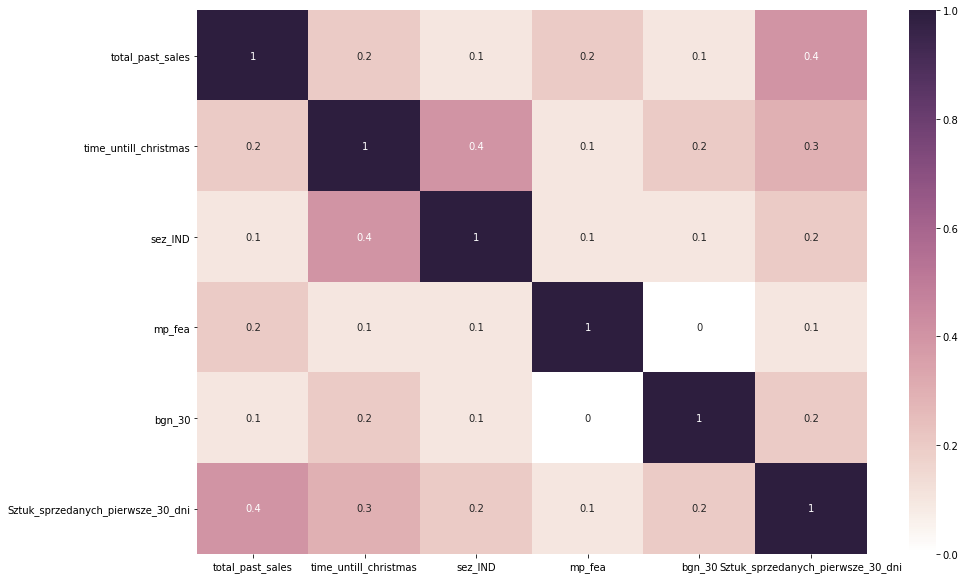

In [6]:
df = df[top_5_features + ['Sztuk_sprzedanych_pierwsze_30_dni']]

plt.figure(figsize=(15, 10))
ax = sns.heatmap(np.abs(df
                        .corr()
                        .round(decimals=1)),
                 cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                 annot=True)

Warto też zobaczyć jak wyglądają wykresy punktowe naszych zmiennych względem zmiennej objaśnianej. 

total_past_sales


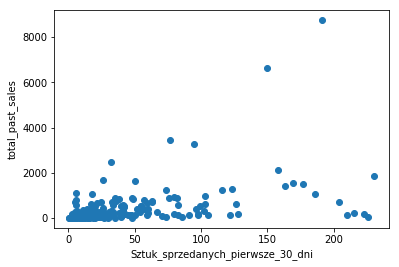

time_untill_christmas


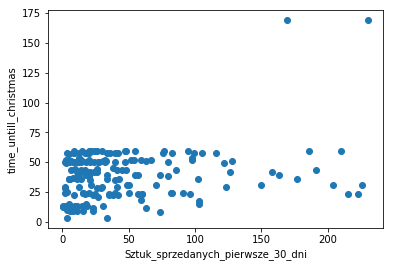

sez_IND


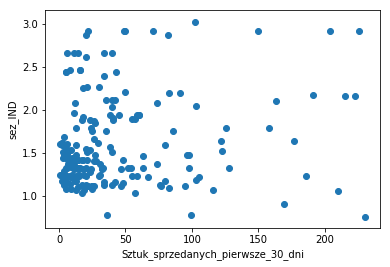

mp_fea


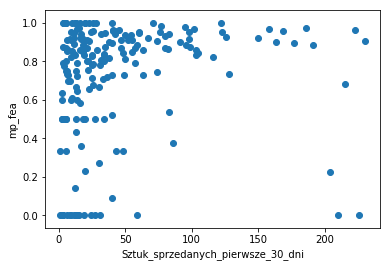

bgn_30


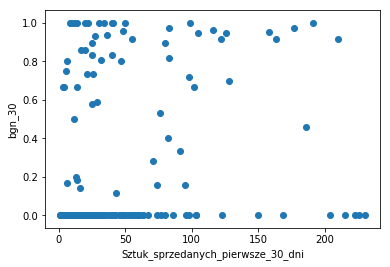

In [7]:
for column in df.columns:
    if column != 'Sztuk_sprzedanych_pierwsze_30_dni':
        print(column)
        plt.scatter(df['Sztuk_sprzedanych_pierwsze_30_dni'], df[column])
        plt.xlabel('Sztuk_sprzedanych_pierwsze_30_dni')
        plt.ylabel(column)
        plt.show()

Na pierwszy rzut oka nasze zmienne nie wyglądają obiecująco. Zobaczymy co uda się z nimi zrobić podczas modelowania.

In [8]:
# Zapisz tabele po przekształceniach jako pkl
df.to_pickle('data/data_after_feature_selection.pkl')